# Телеком 

## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Для лучшего пониманя содержания массивов расшифровка значения столбцов:

**contract**
- `customerID`: код клиента
- `BeginDate`: дата подключения
- `EndDate`: дата завершения пользования услугами
- `Type`: тип оплаты (ежемесячно, раз в год или раз в два года)
- `PaperlessBilling`: метка выставления счёта в бумажном или электронном виде
- `PaymentMethod`: способ оплаты
- `MonthlyCharges`: сумма ежемесячного платёжа
- `TotalCharges`: сумма всех платежей

**personal**
- `customerID`: код клиента
- `gender`: пол клиента
- `SeniorCitizen`: метка пенсионного возраста (старше 60 лет)
- `Partner`: метка семейного положения
- `Dependents`: метка наличия иждивенцев

**internet**
- `customerID`: код клиента
- `InternetService`: метод интернет подключения
- `OnlineSecurity`: метка наличия блокировки небезопасных сайтов
- `OnlineBackup`: метка использования облачного хранилища
- `DeviceProtection`: метка наличия антивируса
- `TechSupport`: метка наличия выделенной линии технической поддержки 
- `StreamingTV`: метка использования стримингового телевидения
- `StreamingMovies`: метка возможности использования хранилища фильмов

**phone**
- `customerID`: код клиента
- `MultipleLines`: подключено ли несколько телефонный линий одновременно

## Предподготовка

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

## Изучение и подготовка данных

In [2]:
# функция первичного анализа данных
def info_df(df):
    print('Размер таблицы', df.shape)
    df.info()
    display(df.head(5))
    display(df.describe())
    print('Количество дубликатов ID пользователя', df['customerID'].duplicated().sum())

In [3]:
c_df = pd.read_csv('/datasets/final_provider/contract.csv')
p_df = pd.read_csv('/datasets/final_provider/personal.csv')
i_df = pd.read_csv('/datasets/final_provider/internet.csv')
ph_df = pd.read_csv('/datasets/final_provider/phone.csv')

### Анализ исходных массивов

In [4]:
print('Массив ДОГОВОР')
info_df(c_df)

Массив ДОГОВОР
Размер таблицы (7043, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Количество дубликатов ID пользователя 0


In [5]:
print('столбец СПОСОБ ОПЛАТЫ')
display(c_df['PaymentMethod'].value_counts())
print('столбец ТИП ОПЛАТЫ')
display(c_df['Type'].value_counts())

столбец СПОСОБ ОПЛАТЫ


Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

столбец ТИП ОПЛАТЫ


Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [6]:
print('Массив ПЕРСОНАЛЬНЫЕ ДАННЫЕ КЛИЕНТА')
info_df(p_df)

Массив ПЕРСОНАЛЬНЫЕ ДАННЫЕ КЛИЕНТА
Размер таблицы (7043, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Количество дубликатов ID пользователя 0


In [7]:
print('Массив ИНТЕРНЕТ УСЛУГИ')
info_df(i_df)

Массив ИНТЕРНЕТ УСЛУГИ
Размер таблицы (5517, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,0581-BXBUB,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Количество дубликатов ID пользователя 0


In [8]:
print('Массив ТЕЛЕФОНИЯ')
info_df(ph_df)

Массив ТЕЛЕФОНИЯ
Размер таблицы (6361, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,0581-BXBUB,No
freq,1,3390


Количество дубликатов ID пользователя 0


**Выводы:**

- пропуски отсутствуют;
- дубликаты отсутствуют;
- общее количество заключенных контрактов с пользователями 7043, из которых с доступом в интернет 5517, а телефония 6361;
- требуется переименование столбцов;
- требуется изменение типа полей в таблице ДОГОВОР BeginDate, EndDate (в формат даты) и TotalCharges (в числовой тип);
- целевой признак в таблице ДОГОВОР(столбец EndDate) имеет значение "No" и несет смысл "по настоящее время" (т.е. на дату 1 февраля 2020);
- для корректной обработки значение "No" в столбце EndDate мы можем заменить на значение последней даты обновления данных (01 февраля 2020).

### Предобработка данных

#### Переименование столбцов

In [9]:
c_df = c_df.rename(columns={'customerID': 'CustomerID'})
p_df = p_df.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender'})
i_df = i_df.rename(columns={'customerID': 'CustomerID'})
ph_df = ph_df.rename(columns={'customerID': 'CustomerID'})

#### Добавление целевого признака

Создадим целевой признак `Trgt` на основании занчения столбца EndDate `No` в таблице ДОГОВОР

In [10]:
c_df['Trgt'] = (c_df['EndDate'] != 'No').astype(int)
c_df.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Trgt
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


#### Обработка столбцов `BeginDate`, `EndDate` и `TotalCharges`

In [11]:
c_df['BeginDate']= pd.to_datetime(c_df['BeginDate'], format='%Y-%m-%d')

# для преобразования типа столбща 'EndDate' необходимо все значения привести вид даты
c_df['EndDate'] = c_df['EndDate'].replace(['No'], ['2020-02-01'])
c_df['EndDate']= pd.to_datetime(c_df['EndDate'], format='%Y-%m-%d')

# у новых клиентов (договор меньше месяца) значение столбца TotalCharges пустое, заполним его значением 0:
c_df['TotalCharges'] = pd.to_numeric(c_df['TotalCharges'], errors ='coerce')
c_df['TotalCharges'] = c_df['TotalCharges'].fillna(0)

c_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Trgt              7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


#### Создание столбца `IntTime` (для подсчёта длительности действия договора)

In [12]:
c_df['IntTime'] = (c_df['EndDate'] - c_df['BeginDate']).dt.days
c_df.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Trgt,IntTime
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61


#### Создание объединенного массива

In [13]:
df = c_df.merge(p_df, how='left', on='CustomerID') \
    .merge(i_df, how='left', on='CustomerID') \
    .merge(ph_df, how='left', on='CustomerID')
print('Значения CustomerID уникальные?', df['CustomerID'].is_unique)
df = df.set_index('CustomerID')
df.info()

Значения CustomerID уникальные? True
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Trgt              7043 non-null   int64         
 8   IntTime           7043 non-null   int64         
 9   Gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null

#### Обработка пропусков, появившихся в следствие объединения из-за отсутствия услуг у пользователя

In [14]:
# пропуски заполняем по логике: отсутствующее значение свидетельствует о отсутствии услуги
for clmn in ('InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'):
    df[clmn] = df[clmn].fillna('No')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Trgt              7043 non-null   int64         
 8   IntTime           7043 non-null   int64         
 9   Gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity

**ДАННЫЕ ПОДГОТОВЛЕНЫ ДЛЯ ДАЛЬНЕЙШЕГО ИЗУЧЕНИЯ**

## Исследовательский анализ данных

### Иссладование данных для отдела маркетинга

#### Сравните распределения величин ежемесячных платежей (MonthlyCharges) всех клиентов и бывших пользователей

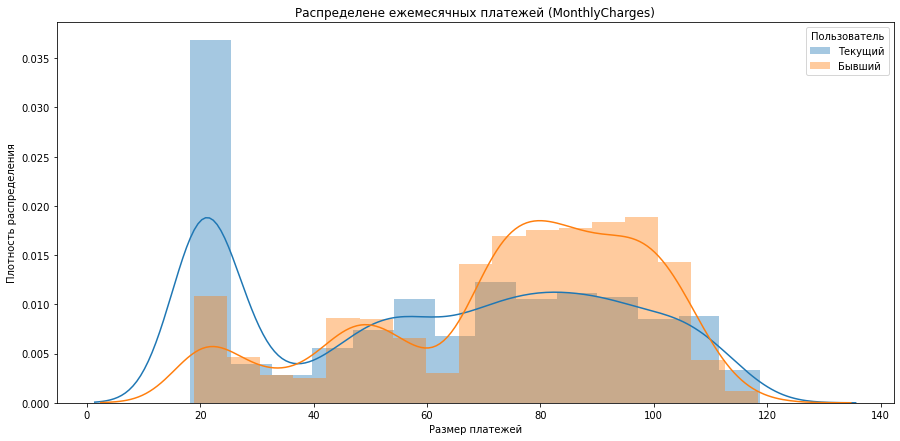

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(15, 7))
sns.distplot(df.query('Trgt==0')['MonthlyCharges'], label='Текущий').set_title('Распределене ежемесячных платежей (MonthlyCharges)')
sns.distplot(df.query('Trgt==1')['MonthlyCharges'], label='Бывший')
plt.setp(axes, xlabel='Размер платежей', ylabel='Плотность распределения')
plt.legend(loc='upper right', title='Пользователь')
plt.show()

#### Статистика по клиентам и бывшим пользователям

In [16]:
#разделим массив на 2 (текущие клиенты и ушедшие пользователи)
df_n = df[df['Trgt'] == 0]
df_t = df[df['Trgt'] == 1]

In [17]:
num_clmns = ['MonthlyCharges', 'TotalCharges', 'IntTime']
print('Статистика по текущим клиентам:')
display(df_n[num_clmns].describe())
print('Статистика по ушедшим пользователям:')
display(df_t[num_clmns].describe())

Статистика по текущим клиентам:


,MonthlyCharges,TotalCharges,IntTime
count,5174.000000,5174.000000,5174.000000
mean,61.265124,2549.911442,1144.447236
std,31.092648,2329.954215,733.897937
min,18.250000,0.000000,0.000000
25%,25.100000,572.900000,457.000000
50%,64.425000,1679.525000,1157.000000
75%,88.400000,4262.850000,1857.000000
max,118.750000,8672.450000,2191.000000


Статистика по ушедшим пользователям:


,MonthlyCharges,TotalCharges,IntTime
count,1869.000000,1869.000000,1869.000000
mean,74.441332,1531.796094,547.352060
std,24.666053,1890.822994,594.389607
min,18.850000,18.850000,30.000000
25%,56.150000,134.500000,61.000000
50%,79.650000,703.550000,304.000000
75%,94.200000,2331.300000,883.000000
max,118.350000,8684.800000,2191.000000


#### Гистограммы распределения

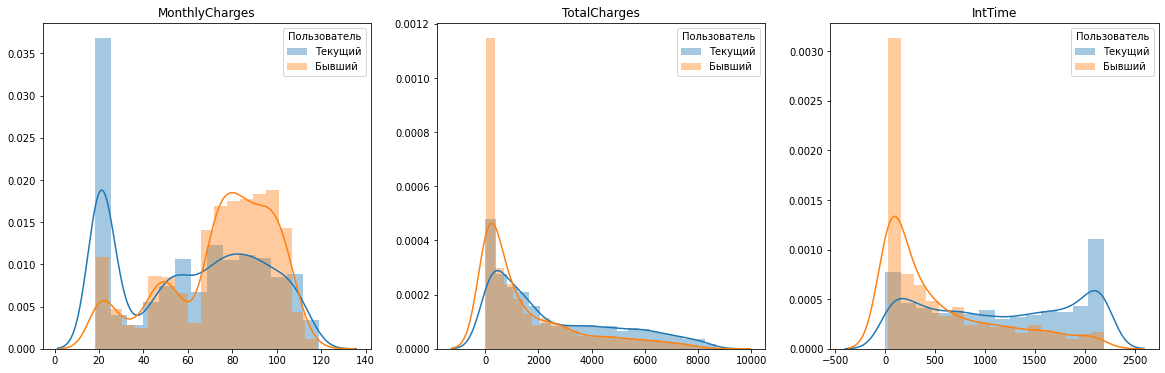

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for clmn, ax in zip(num_clmns, axes.flat):
    sns.distplot(df.query('Trgt==0')[clmn], label='Текущий', ax=ax).set_title(clmn)
    sns.distplot(df.query('Trgt==1')[clmn], label='Бывший', ax=ax).set_title(clmn)
    ax.legend(loc='upper right', title='Пользователь')

plt.setp(axes, xlabel=None, ylabel=None)
plt.show()

#### Сравнение поведения клиентов и бывших пользователей (

In [19]:
# определение перечня столбцов с категориальными переменными
cat_clmns = ['Trgt',
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'Gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'InternetService', 
    'OnlineSecurity', 
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    'StreamingTV', 
    'StreamingMovies', 
    'MultipleLines']

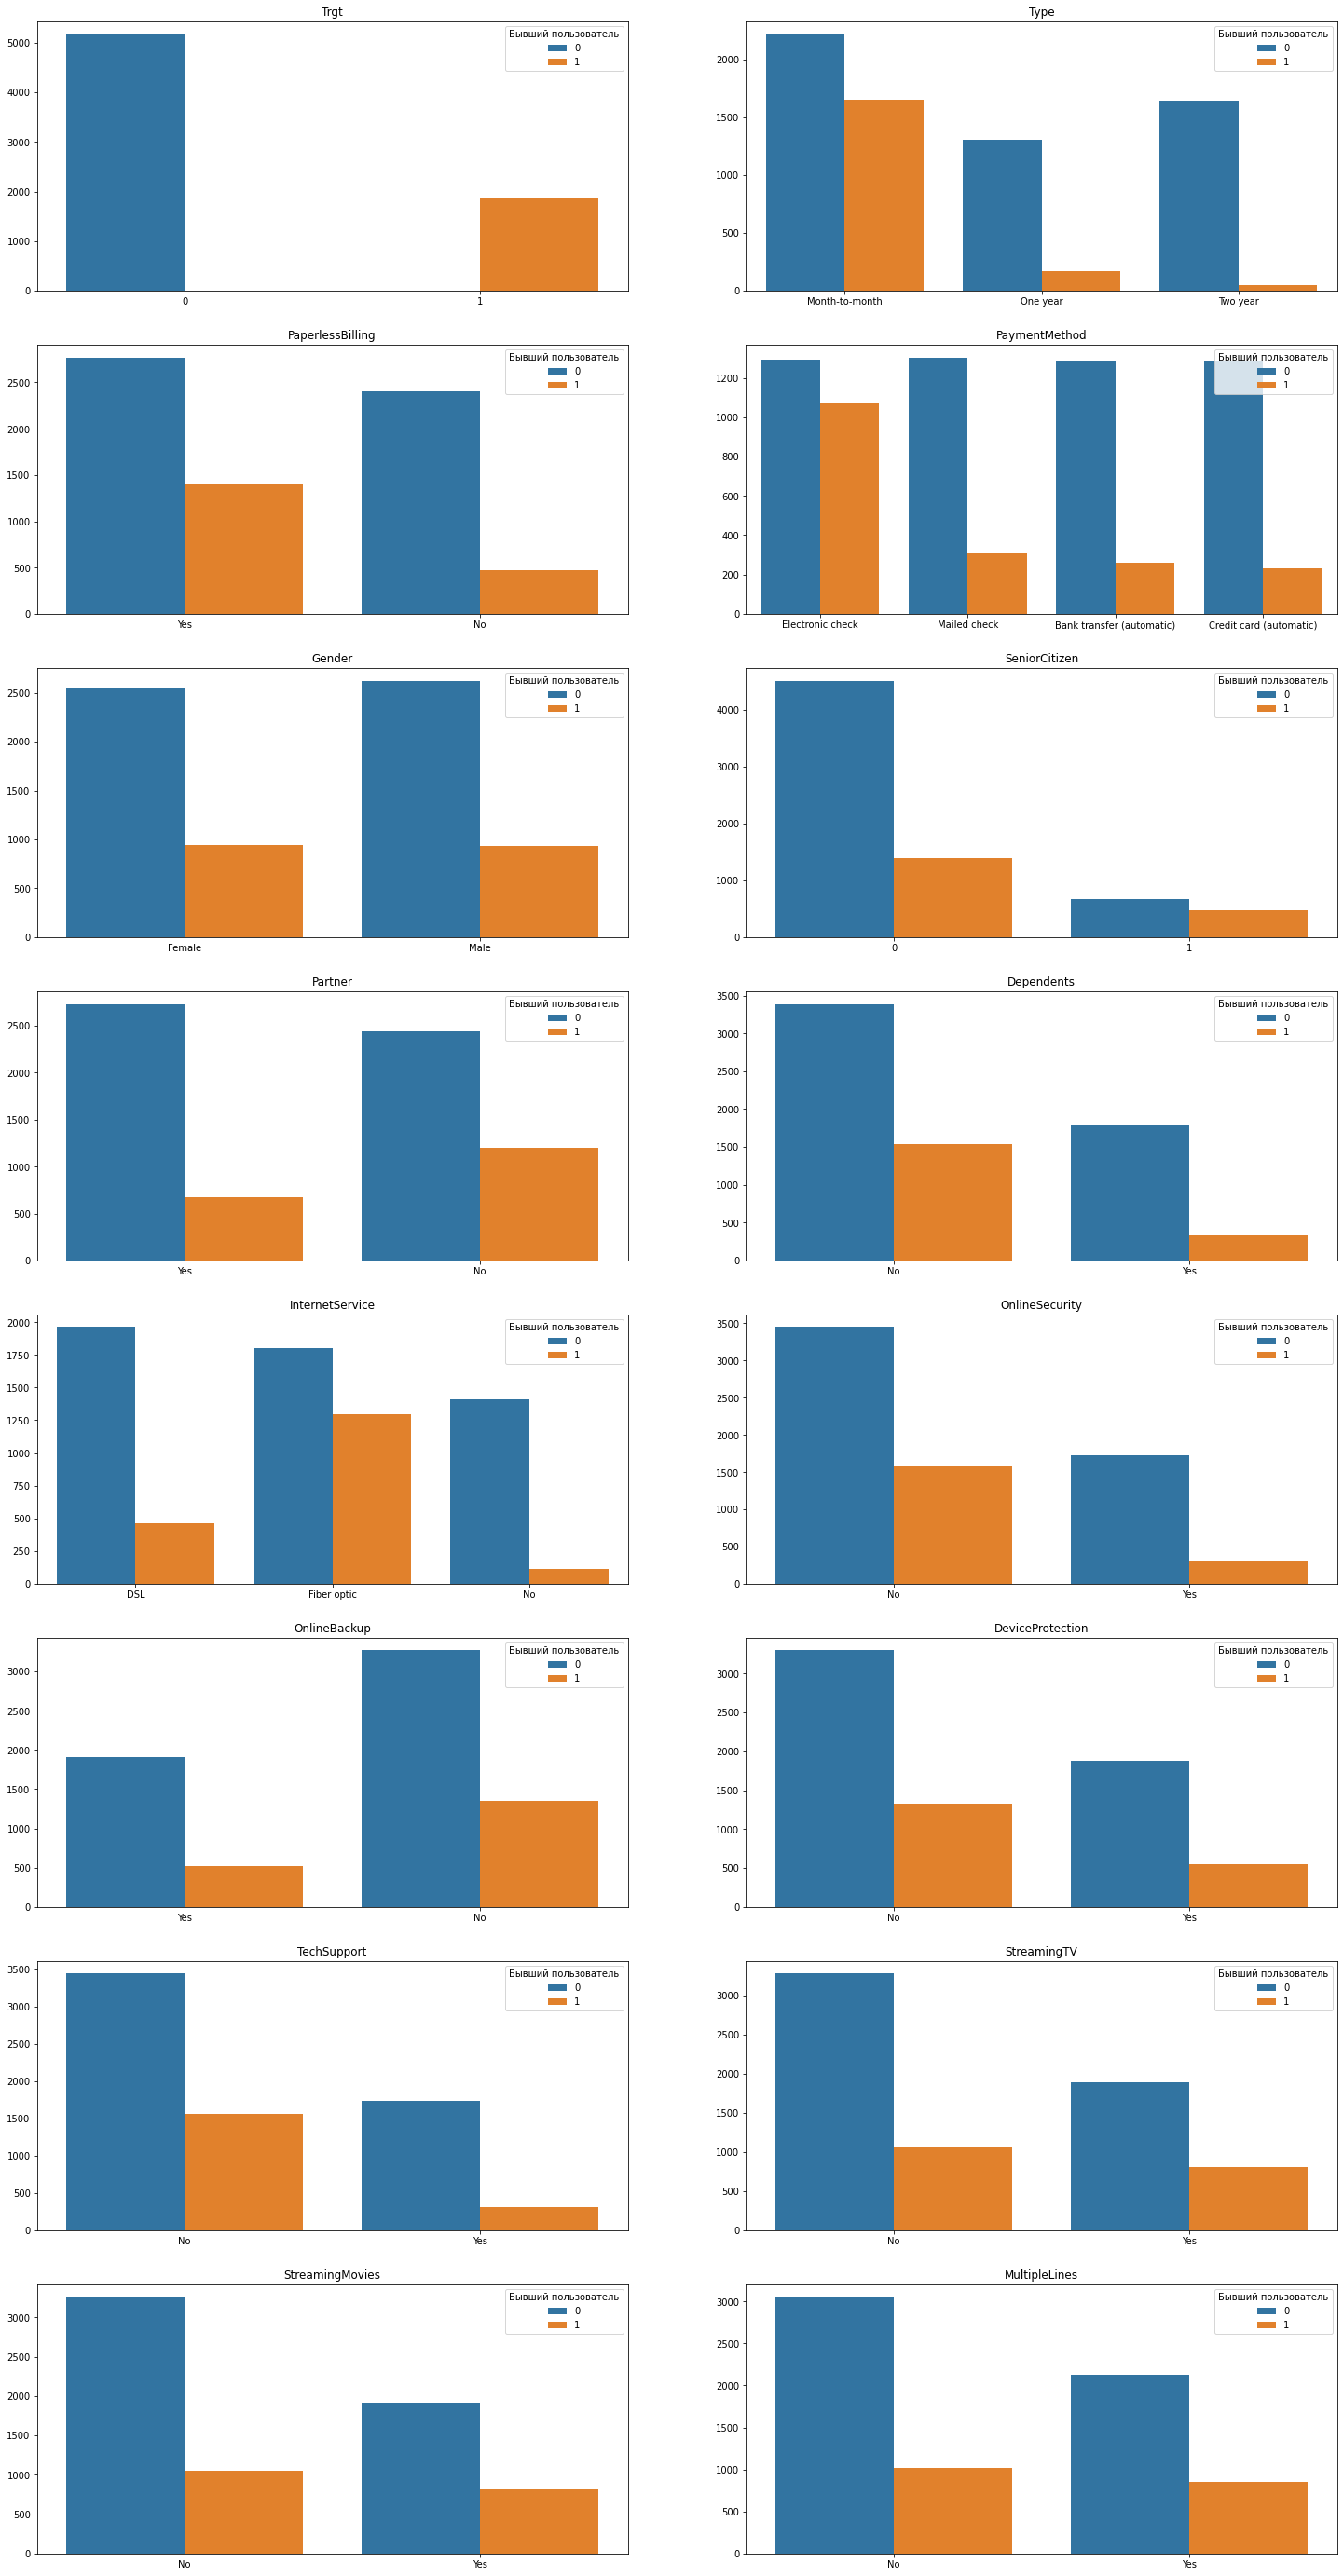

In [20]:
fig, axes = plt.subplots(8, 2, figsize=(25, 50))
for clmn, ax in zip(cat_clmns, axes.flat):
    sns.countplot(clmn, hue='Trgt', data=df, ax=ax).set_title(clmn)
    ax.legend(loc='upper right', title='Бывший пользователь')

plt.setp(axes, xlabel=None, ylabel=None)
plt.show()

**Выводы:**

- Целевая переменная показывает, что лишь 25% от всех пользователей прекращают использование услуг
- Наибольшее (40%) количество пользователей используют помесячную оплату
- Большинство предпочитает электронные чеки
- Наиболее популярный способ оплаты - электронный
- Значения пола и семейного положения в целом равны
- Предсказуемо пенсионеров не большое количество, а абонентов с иждивенцами около 30%
- Наиболее популярный способ подключения к интернету оптоволокно
- Дополнительные услуги интернета пользуются популярностью в среднем у трети пользователей
- Около 40% пользователей пользуются несколькими телефонными линиями

## Моделирование

### Предобработка исходных данных для обучения

In [21]:
# удаление столбцов BeginDate и EndDate, которые не несут обучающей ценности и могут негативно повлиять на обучение модели
del df['BeginDate'], df['EndDate']
# также можно утверждать, что столбец TotalCharges несет в себе похожий смысл со столбцом IntTime, т.к. 
# чем больше время использования услуг, тем больше общая сумма всех трат клиента
del df['TotalCharges']

In [22]:
# применение OHE
df = pd.get_dummies(df, drop_first=True)
df.head()

,MonthlyCharges,Trgt,IntTime,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Gender_Male,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
CustomerID,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,29.85,0,31,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0
5575-GNVDE,56.95,0,1036,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0
3668-QPYBK,53.85,1,61,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0
7795-CFOCW,42.30,0,1371,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0
9237-HQITU,70.70,1,61,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0


In [23]:
# разделение данных на целевые и признаки 
trgt = df['Trgt'] 
ftrs = df.drop(columns=['Trgt'])

In [24]:
# разделение на обучающие и тестовую выборки
ftrs_trn, ftrs_tst, trgt_trn, trgt_tst = train_test_split(ftrs, trgt, test_size=0.2, random_state=12345)

In [25]:
num_clmns = ['MonthlyCharges', 'IntTime']
# масштабирование количественных значений
scaler = StandardScaler()

scaler.fit(ftrs_trn[num_clmns])

ftrs_trn = ftrs_trn.copy()
ftrs_trn[num_clmns] = scaler.transform(ftrs_trn[num_clmns])

ftrs_tst = ftrs_tst.copy()
ftrs_tst[num_clmns] = scaler.transform(ftrs_tst[num_clmns])

In [26]:
print('features_train', len(ftrs_trn))
print('features_test', len(ftrs_tst))

features_train 5634
features_test 1409


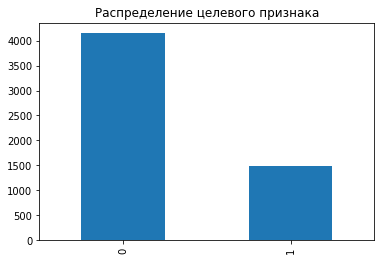

In [27]:
trgt_trn.value_counts().plot(kind='bar', title='Распределение целевого признака')
plt.show()

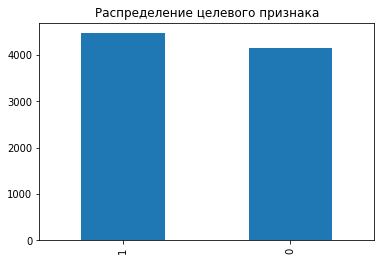

In [28]:
# для устраненя дисбаланса классов проведём upsampling

def upsmpl(ftrs, trgt, rpt):
    ftrs_z = ftrs[trgt == 0]
    ftrs_o = ftrs[trgt == 1]
    trgt_z = trgt[trgt == 0]
    trgt_o = trgt[trgt == 1]
    ftrs_upsmpl = pd.concat([ftrs_z]+[ftrs_o]*rpt)
    trgt_upsmpl = pd.concat([trgt_z]+[trgt_o]*rpt)
    ftrs_upsmpl, trgt_upsmpl = shuffle(ftrs_upsmpl, trgt_upsmpl, random_state=12345)
    return ftrs_upsmpl, trgt_upsmpl

ftrs_trn, trgt_trn = upsmpl(ftrs_trn, trgt_trn, 3)

trgt_trn.value_counts().plot(kind='bar', title='Распределение целевого признака')
plt.show()

### Обучение моделей

#### LogisticRegression

In [29]:
%%time
param_grid = {'C': [850, 900, 1000]}

model = LogisticRegression(solver='lbfgs', n_jobs=-1)

lr = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
lr.fit(ftrs_trn, trgt_trn)

print(lr.best_params_)

predicted_prob = lr.best_estimator_.predict_proba(ftrs_tst)[:, 1]
print('LogisticRegression ROC-AUC target test score', roc_auc_score(trgt_tst, predicted_prob))

{'C': 900}
LogisticRegression ROC-AUC target test score 0.843766170556139
CPU times: user 5.45 s, sys: 6.19 s, total: 11.6 s
Wall time: 11.7 s


#### RandomForestClassifier

In [30]:
%%time
param_grid = {
    'max_depth': [20, 25, 30],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2, 10],
    'n_estimators': [75, 100, 125], 
}

model = RandomForestClassifier(random_state=12345)

rfc = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
rfc.fit(ftrs_trn, trgt_trn)

print(rfc.best_params_)

predicted_prob = rfc.best_estimator_.predict_proba(ftrs_tst)[:, 1]
print('RandomForestClassifier ROC-AUC target test score', roc_auc_score(trgt_tst, predicted_prob))

{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 125}
RandomForestClassifier ROC-AUC target test score 0.8493698286241258
CPU times: user 1min 22s, sys: 0 ns, total: 1min 22s
Wall time: 1min 22s


#### CatBoostClassifier

In [31]:
%%time
param_grid = {
    'learning_rate': [0.2, 0.3, 0.4],
    'iterations': [90, 100, 110],
    'l2_leaf_reg': [0.25, 0.5, 1, 2, 3]
}

model = CatBoostClassifier(random_state=12345, verbose=0)

cbc = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
cbc.fit(ftrs_trn, trgt_trn)

print(cbc.best_params_)

predicted_prob = cbc.best_estimator_.predict_proba(ftrs_tst)[:, 1]
print('CatBoostClassifier ROC-AUC target test score', roc_auc_score(trgt_tst, predicted_prob))

{'iterations': 110, 'l2_leaf_reg': 0.5, 'learning_rate': 0.4}
CatBoostClassifier ROC-AUC target test score 0.9045367215718422
CPU times: user 1min 1s, sys: 2.67 s, total: 1min 4s
Wall time: 2min 43s


##### Определение важности признаков

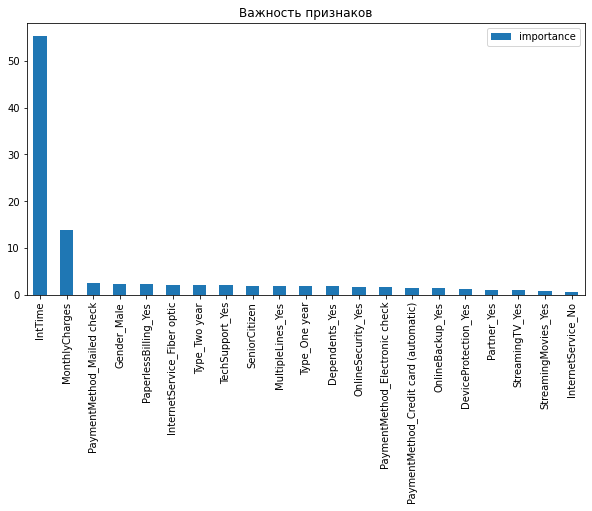

In [32]:
pd.DataFrame(cbc.best_estimator_.feature_importances_, index = ftrs_tst.columns,\
             columns=['importance']).sort_values(by='importance',\
                                                 ascending=False).plot(kind='bar', figsize=(10, 5), title='Важность признаков')
plt.show()

# Результат исследования

В данной работе проведено обучение моделей для предсказания оттока клиентов оператора сотовой связи.

1. По обработанным исходным данным были сделаны предварительные выводы:
- пропуски отсутствуют и дубликаты в исходных данных отсутствуют;
- общее количество заключенных контрактов с пользователями 7043, из которых с доступом в интернет 5517, а телефония 6361;
- требуется изменение типа полей в таблице ДОГОВОР BeginDate, EndDate (в формат даты) и TotalCharges (в числовой тип);
- данные требуют незначительной подготовки;
- для целевой функции моделирования подходит значение `No` столбца  `EndDate`.

2. Для анализа модели, были добавлены 2 новых столбца - целевой признак Trgt(действующий абонент или нет) и IntTime(количество дней пользования услугами)


3. После этого был проведен исследовательский анализ данных:
- сравнение распределения величин ежемесячных платежей (MonthlyCharges) всех клиентов и тех, кто ушёл;
- для каждой группы посчитана статистика;
- построены гистограммы распределения;
- предоставлены выводы для `отдела маркетинга`;
- в целом по результатам анализа выявлены типы клиентов потенциально склонныхк смене оператора и наиболее востребованные способы их удержанияк. 

5. Для обучения модели проведена подготовка данных: удалены ненужные столбцы, применена техника OHE, датафрейм был разделен на обучающую и тестовую выборки, проведено масштабирование количественных признаков и проведен upsample.


6. В результате обучения моделей, лучший результат показала CatBoostClassifier: согласно требованиям к целевому показателию ROC-AUC в 0.905, что выше максимального требуемого значения 0,88.


7. После моделирования графически определена важность признаков для определения лояльности клиентов: время пользования услугами и стоимость услуг в месяц.